### svm

利用SMO方法实现svm

In [39]:
import numpy as np
import time
import matplotlib.pyplot as plt

---
#### 一些基本的辅助函数

In [2]:
def loadDataset(filename):
    dataMat=[]
    labelMat=[]
    fr=open(filename)
    for line in fr.readlines():
        #print(line)
        lineArr=line.strip().split('\t')
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

X_train,y_train=loadDataset('testSet.txt')

In [3]:
# 返回在0~m样本范围内,和i不同的随机的一个值
def selectJrand(i,m):
    j=i
    while(j==i):
        j=int(np.random.uniform(0,m))
    
    return j


In [4]:
# 把alpha clip到H和L范围内
def clipAlpha(aj,H,L):
    if aj>H:
        aj=H
    elif aj<L:
        aj=L
    return aj


In [30]:
# dataSe: 是数据集
# labels: 是标签,+1和-1
# C是 alpha的最大值,约束条件
# toler 误差容忍
# maxIter: alpha不再变化的最大迭代次数,尝试这么多次的迭代alpha都不在变化后,认为找到最优的alpha.
def smo(dataSet,labels,C,toler,maxIter):
    X=np.mat(dataSet)
    y=np.mat(labels).transpose()
    b=0
    m,n=X.shape
    #alphas=np.zeros([m,1],np.float32)
    alphas = np.mat(np.zeros((m,1),np.float32))
    print(alphas)
    iterI=0
    
    #debug
    DEBUG_SVM=False
    if DEBUG_SVM == True:
        #print("X.shape:%s,y.shape:%s"%(X.shape,y.shape))
        #print("X:%s,y:%s"%(X,y))
        print(maxIter)
    while(iterI<maxIter):# end
        # update
        alphaPairsChanged=0
        for i in range(m):# end
            fXi=float(np.multiply(alphas,y).T*(X*X[i,:].T))+b
            
            Ei=fXi-float(y[i])
            
            if DEBUG_SVM == True:
                #print("alpha:%s",alphas)
                print("[i:%d] fXi:%s,y[%d]:%s,Ei:%s" %(i,fXi,i,y[i],Ei))

            
            # KKT conditions
            # 第一: 偏差大于 toler. y[i]表符号.
            # 第二: alphas[i]满足0~C,而且不能取边界; 这个边界问题我还没搞懂
            if ((y[i]*Ei<-toler) and alphas[i]<C ) or ((y[i]*Ei>toler)and alphas[i]>0): #kkt条件,参考<<支持向量机通俗导论>>及<<支持向量机导论>>
                j=selectJrand(i,m)
                fXj=float(np.multiply(alphas,y).T*(X*X[j,:].T))+b
                Ej=fXj-y[j]

                if DEBUG_SVM == True:
                    print("[j:%d] fXj:%s,y[%d]:%s,Ej:%s" %(j,fXj,j,y[j],Ej))
                
                alpha_i_old=alphas[i].copy()
                alpha_j_old=alphas[j].copy()
                if y[i]!=y[j]:
                    L=max(0,alphas[j]-alphas[i])
                    H=min(C,C+alphas[j]-alphas[i])
                else:
                    L=max(0,alphas[i]+alphas[j]-C)
                    H=min(C,alphas[j]+alphas[i]) #### 2018-08-15debug issue:   这部分的逻辑出现问题了.注意同号时候要相加.
                if L==H: #### 2018-08-15debug issue:   这部分丢掉了L和H相等的时候,是alphas[i]和alphas[j]同为0时,此时后面没必要再去计算,更新量都为0.
                    print("L==H")
                    continue
                eta=2.0*X[i,:]*X[j,:].T - X[i,:]*X[i,:].T - X[j,:]*X[j,:].T
                if DEBUG_SVM == True:
                    print("eta:%s"%eta)
                    print("i:%d,X[i,:]:%s" %(i,X[i,:]))
                    print("j:%d,X[j,:]:%s" %(j,X[j,:]))
                    print("X[%d,:]*X[%d,:].T:%s"%(i,j,X[i,:]*X[j,:].T ))
                    print("X[%d,:]*X[%d,:].T:%s"%(i,i,X[i,:]*X[i,:].T ))
                    print("X[%d,:]*X[%d,:].T:%s"%(j,j,X[j,:]*X[j,:].T ))
                    
                if eta>=0:
                    print("eta >=0")
                    continue
                alphas[j]-=y[j]*(Ei-Ej)/eta # 更新alpha[j]
                alphas[j]=clipAlpha(alphas[j],H,L)
                if DEBUG_SVM == True:
                    print("Ei-Ej:%s"%(Ei-Ej))
                    print("L:%s,H:%s"%(L,H))
                    print("(Ei-Ej)/eta:%s" %((Ei-Ej)/eta))
                    print("alphas[%d]:%d"%(j,alphas[j]))

                if(np.abs(alphas[j]-alpha_j_old)<0.00001):
                    print("j not move")
                    continue
                alphas[i]+=y[j]*y[i]*(alpha_j_old-alphas[j])
                
                b1=b-Ei-y[i]*(alphas[i]-alpha_i_old)*X[i,:]*X[i,:].T-y[j]*(alphas[j]-alpha_j_old)*X[j,:]*X[j,:].T
                b2=b-Ej-y[i]*(alphas[i]-alpha_i_old)*X[i,:]*X[i,:].T-y[j]*(alphas[j]-alpha_j_old)*X[j,:]*X[j,:].T
                if (0<alphas[i]) and (C>alphas[i]):
                    b=b1
                elif (0<alphas[j]) and (C>alphas[j]):
                    b=b2
                else:
                    b=(b1+b2)/2.0
                    
                alphaPairsChanged+=1
                print("iter: %d i:%d, pairs changed %d" % (iterI,i,alphaPairsChanged))
        #if DEBUG_SVM==True:
        #    break
            
        if alphaPairsChanged==0:
            iterI+=1
        else:
            iterI=0
        print("iteration num: %d"%iterI)
    
    return b,alphas
                
                
            
        # break
    
b,alphas=smo(X_train,y_train,0.6,0.001,40)    

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
iter: 0 i:0, pairs changed 1
L==H
iter: 0 i:4, pairs changed 2
iter: 0 i:5, pairs changed 3
iter: 0 i:8, pairs changed 4
iter: 0 i:13, pairs changed 5
L==H
L==H
j not move
j not move
j not move
j not move
j not move
L==H
L==H
L==H
j not move
iter: 0 i:66, pairs changed 6
j not move
L==H
L==H
j not 

iteration num: 3
j not move
iter: 3 i:23, pairs changed 1
j not move
j not move
j not move
j not move
iteration num: 0
j not move
j not move
j not move
j not move
j not move
iter: 0 i:55, pairs changed 1
iteration num: 0
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 1
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 2
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 3
j not move
j not move
j not move
iter: 3 i:52, pairs changed 1
j not move
j not move
iteration num: 0
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 1
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 2
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 3
j not move
j not move
iter: 3 i:29, pairs changed 1
j not move
j not move
j not move
iteration num: 0
j not move
j not move
j not move
iter: 0 i:52, pairs changed 1
j not move
ite

j not move
j not move
j not move
j not move
j not move
iteration num: 4
j not move
j not move
j not move
j not move
j not move
iteration num: 5
j not move
j not move
iter: 5 i:52, pairs changed 1
j not move
j not move
iteration num: 0
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 1
j not move
j not move
j not move
j not move
j not move
iter: 1 i:55, pairs changed 1
iteration num: 0
j not move
L==H
j not move
j not move
j not move
j not move
iteration num: 1
j not move
L==H
j not move
j not move
j not move
j not move
iteration num: 2
j not move
L==H
j not move
j not move
j not move
j not move
iteration num: 3
j not move
L==H
j not move
j not move
j not move
j not move
iteration num: 4
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 5
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 6
j not move
L==H
j not move
j not move
j not move
j not move
iteration num: 7
j not move
L==H
j not move
j 

j not move
j not move
j not move
j not move
j not move
iteration num: 15
j not move
iter: 15 i:29, pairs changed 1
j not move
j not move
j not move
iteration num: 0
j not move
j not move
j not move
j not move
iter: 0 i:55, pairs changed 1
iteration num: 0
j not move
j not move
j not move
j not move
j not move
iteration num: 1
j not move
j not move
j not move
j not move
j not move
iteration num: 2
j not move
j not move
j not move
j not move
j not move
iteration num: 3
j not move
j not move
j not move
j not move
j not move
iteration num: 4
j not move
j not move
j not move
j not move
iter: 4 i:55, pairs changed 1
iteration num: 0
j not move
j not move
j not move
j not move
j not move
iteration num: 1
iter: 1 i:17, pairs changed 1
j not move
j not move
j not move
j not move
iteration num: 0
j not move
j not move
j not move
j not move
j not move
iteration num: 1
j not move
j not move
j not move
j not move
j not move
iteration num: 2
j not move
j not move
j not move
j not move
j not move
ite

j not move
j not move
j not move
iteration num: 7
j not move
j not move
j not move
L==H
j not move
j not move
iteration num: 8
j not move
L==H
j not move
L==H
j not move
j not move
iteration num: 9
j not move
L==H
j not move
L==H
j not move
j not move
iteration num: 10
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 11
j not move
j not move
j not move
j not move
j not move
j not move
iteration num: 12
j not move
L==H
j not move
L==H
j not move
j not move
iteration num: 13
j not move
j not move
j not move
L==H
j not move
j not move
iteration num: 14
j not move
L==H
j not move
j not move
j not move
j not move
iteration num: 15
j not move
L==H
j not move
L==H
j not move
j not move
iteration num: 16
j not move
L==H
j not move
L==H
j not move
j not move
iteration num: 17
j not move
L==H
j not move
j not move
iter: 17 i:54, pairs changed 1
j not move
iteration num: 0
j not move
j not move
j not move
j not move
j not move
iteration num: 1
j not move
j not move

In [73]:
def show_support_vectos(alphas,dataSet,labels):
    X=np.mat(dataSet)
    y=np.mat(labels).transpose()
    m=alphas.shape
    pos=[]
    for i in range(m[0]):
        if alphas[i]>0:
            pos.append(i)
            print("X[%d]:%s   y[%d]:%s" %(i,X[i],i,y[i]))
    
    return pos

XS=show_support_vectos(alphas,X_train,y_train)

X[17]:[[ 4.658191  3.507396]]   y[17]:[[-1.]]
X[29]:[[ 3.457096 -0.082216]]   y[29]:[[-1.]]
X[55]:[[ 6.080573  0.418886]]   y[55]:[[ 1.]]


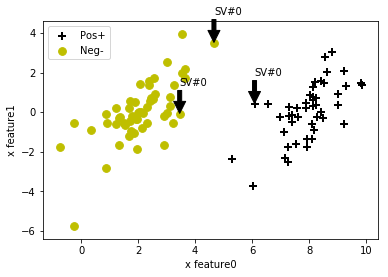

In [88]:
X=np.mat(X_train)
y=np.mat(y_train).transpose()
neg = np.where(y==-1)
pos = np.where(y==1)
neg=neg[0]
pos=pos[0]
#rint(neg.shape)
#rint(neg)
axes = plt.gca()
X_neg=np.zeros([neg.shape[0],2],np.float32)
X_pos=np.zeros([pos.shape[0],2],np.float32)
for i in range(neg.shape[0]):
    X_neg[i]=X[neg[i]]
for i in range(pos.shape[0]):
    X_pos[i]=X[pos[i]]
    
axes.scatter(X_pos[:,0], X_pos[:,1], marker='+', c='k', s=60, linewidth=2, label="Pos+")
axes.scatter(X_neg[:,0], X_neg[:,1], c='y', s=60, label="Neg-")
axes.set_xlabel("x feature0")
axes.set_ylabel("x feature1")
axes.legend(frameon= True, fancybox = True);


for i in XS:
    plt.annotate(
    # Label and coordinate
    'SV#0', xy=(X[i,0],X[i,1]), xytext=(X[i,0],X[i,1]+1.414),
    # Custom arrow
    arrowprops=dict(facecolor='black', shrink=0.02))
